# Predicting Average Ratings of Board Games
#### Galen Ballew, 2017
#### Metis Data Science

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, sklearn
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
print("Python Version:", sys.version)
print()
print("Pandas Version:", pd.__version__)
print()
print("Numpy Version:", np.__version__)
print()
print("Sklearn:", sklearn.__version__)

Python Version: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

Pandas Version: 0.19.2

Numpy Version: 1.11.3

Sklearn: 0.18.1


In [30]:
import warnings
warnings.filterwarnings('ignore')

### Data Munging

In [34]:
#%%writefile spider.py
import re

from bs4 import BeautifulSoup

from scrapy.spiders import CrawlSpider
from scrapy.item import Item, Field
from scrapy.crawler import CrawlerProcess

#return items
class Game(Item):
    id = Field()
    title = Field()
    geek_rate = Field()
    avg_rate = Field()
    num_votes = Field()

class GameSpider(CrawlSpider):
    name = 'boardgamegeek_spider'
    allowed_domains = ['boardgamegeek.com']
    #first page of database
    start_urls = ['http://www.boardgamegeek.com/browse/boardgame']
    custom_settings = {'DOWNLOAD_DELAY': 1, 'BOT_NAME': 'Mr. Scraper Bot'}

    def parse(self, response):
        soup = BeautifulSoup(response.body, 'lxml')
        next_page = soup.select('a[title^="next"]')
        if next_page:
            next_page = next_page[0].get('href')
        if next_page:
            yield self.make_requests_from_url(response.urljoin(next_page))
        rows = soup.select('tr#row_')
        for row in rows:
            #instantiate empty class
            g = Game()
            a = row.find_all('a', href=re.compile('^/boardgame'))
            #populate the class instance
            for r in a:
                if r.text:
                    g['id'] = r.get('href').split('/')[2]
                    g['title'] = r.text
            geek_rate, avg_rate, num_votes = row.select('td.collection_bggrating')
            g['geek_rate'] = geek_rate.text.strip()
            g['avg_rate'] = avg_rate.text.strip()
            g['num_votes'] = num_votes.text.strip()
            yield g

scrapy runspider spider.py -o items.csv  

This code is run inside of the scrapy shell. I couldn't figure out how to run it through the ipython kernel. It writes the spider output to items.csv. 

In [ ]:
import csv

filename = 'items.csv'
reader = csv.reader(open(filename))
#skip header line, enter id column
col = next(reader).index('id')
ids = [line[col] for line in reader]
#list unique ids
ids = list(set(ids))
with open('ids.txt', 'w') as f:
    f.write('\n'.join(ids))

In [ ]:
import csv
import time
import requests
from bs4 import BeautifulSoup

def get_val(tag, term):
    try:
        val = tag.find(term)['value'].encode('utf_8', 'ignore')
    except:
        val = 'NaN'
    return val

base = 'http://www.boardgamegeek.com/xmlapi2/thing?id={}&stats=1'
with open('ids.txt') as f:
    ids = [line.strip() for line in f.readlines()]
split = 30
f = open('games.csv', 'w', encoding='utf8')
writer = csv.writer(f)
writer.writerow(('id', 'type', 'name', 'yearpublished', 'minplayers', 'maxplayers', 'playingtime',
                 'minplaytime', 'maxplaytime', 'minage', 'users_rated', 'average_rating',
                 'bayes_average_rating', 'total_owners', 'total_traders', 'total_wanters',
                 'total_wishers', 'total_comments', 'total_weights', 'average_weight'))
for i in range(0, len(ids), split):
    url = base.format(','.join(ids[i:i+split]))
    print('Requesting {}'.format(url))
    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'xml')
    items = soup.find_all('item')
    for item in items:
        gid = item['id']
        gtype = item['type']
        gname = get_val(item, 'name')
        gyear = get_val(item, 'yearpublished')
        gmin = get_val(item, 'minplayers')
        gmax = get_val(item, 'maxplayers')
        gplay = get_val(item, 'playingtime')
        gminplay = get_val(item, 'minplaytime')
        gmaxplay = get_val(item, 'maxplaytime')
        gminage = get_val(item, 'minage')
        usersrated = get_val(item.statistics.ratings, 'usersrated')
        avg = get_val(item.statistics.ratings, 'average')
        bayesavg = get_val(item.statistics.ratings, 'bayesaverage')
        owners = get_val(item.statistics.ratings, 'owned')
        traders = get_val(item.statistics.ratings, 'trading')
        wanters = get_val(item.statistics.ratings, 'wanting')
        wishers = get_val(item.statistics.ratings, 'wishing')
        numcomments = get_val(item.statistics.ratings, 'numcomments')
        numweights = get_val(item.statistics.ratings, 'numweights')
        avgweight = get_val(item.statistics.ratings, 'averageweight')
        writer.writerow((gid, gtype, gname.decode(), gyear.decode(), gmin.decode(), gmax.decode(),
                         gplay.decode(), gminplay.decode(), gmaxplay.decode(), gminage.decode(),
                         usersrated.decode(), avg.decode(), bayesavg.decode(), owners.decode(),
                         traders.decode(), wanters.decode(), wishers.decode(), numcomments.decode(),
                         numweights.decode(), avgweight.decode()))
    time.sleep(2)
f.close()

# Importing the data

In [11]:
#drop blank observations and games with less than 30 ratings
#chose 30 because it is a magic number 
games = pd.read_csv('games_new.csv')
games.dropna(axis=0, inplace=True)
games = games[games['users_rated'] > 30]
games.head(3)

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
2,12715,boardgame,De Bellis Renationis,1997.0,1.0,2.0,180.0,180.0,180.0,14.0,47,6.59894,5.55511,117,2,0,4,16,9,3.5556
5,2771,boardgame,Maginor,2001.0,2.0,4.0,45.0,45.0,45.0,12.0,328,5.49909,5.49931,739,78,3,14,144,38,1.8684
12,24762,boardgame,Medici vs Strozzi,2006.0,2.0,2.0,30.0,30.0,30.0,10.0,1538,6.52968,6.14922,1808,115,53,205,676,194,2.4485


### Exploratory Data Analysis

/home/galen/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


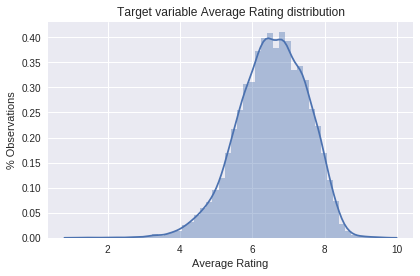

Average Rating Mean 6.548808755797726
Average Rating Standard Deviation 0.9531603581382707 



In [12]:
fig = plt.figure()
sns.set(color_codes="True")
sns.distplot(games['average_rating'], kde=True);
plt.xlabel('Average Rating')
plt.ylabel('% Observations')
plt.title('Target variable Average Rating distribution')
plt.tight_layout()
plt.show();
#fig.savefig('target_mean_rating_hist.png')
y_mean = games['average_rating'].mean()
y_std = games['average_rating'].std()
print('Average Rating Mean {}'.format(y_mean))
print('Average Rating Standard Deviation {} \n'.format(y_std))

Target distribution is just slightly skewed left, but otherwise Gaussian. This is explained by the lack of 10/10 games, which are pragmatically non-existent on BoardGameGeek. Giving a 10 out 10 score would be considered unhelpful and without any critical thought in the review. Similiar phenomena can be seen somewhere like IMDb where the highest rated film of all time, *The Shawshank Redemption*, is rated 9.2 out of 10.  

Mean Squared Error will make for a good error metric since the distribution is continuous and close to Gaussian. 

In [13]:
#remove all the non-numeric Series
games.drop(['id', 'name', 'type'], axis=1, inplace=True)
#make sure all the columns are numbers
games = games.astype('float', copy=False)
games['yearpublished'].dtype

dtype('float64')

In [14]:
#remove games before 1990 and not out yet
games = games[(games['yearpublished'] > 1990) & (games['yearpublished'] < 2016)]

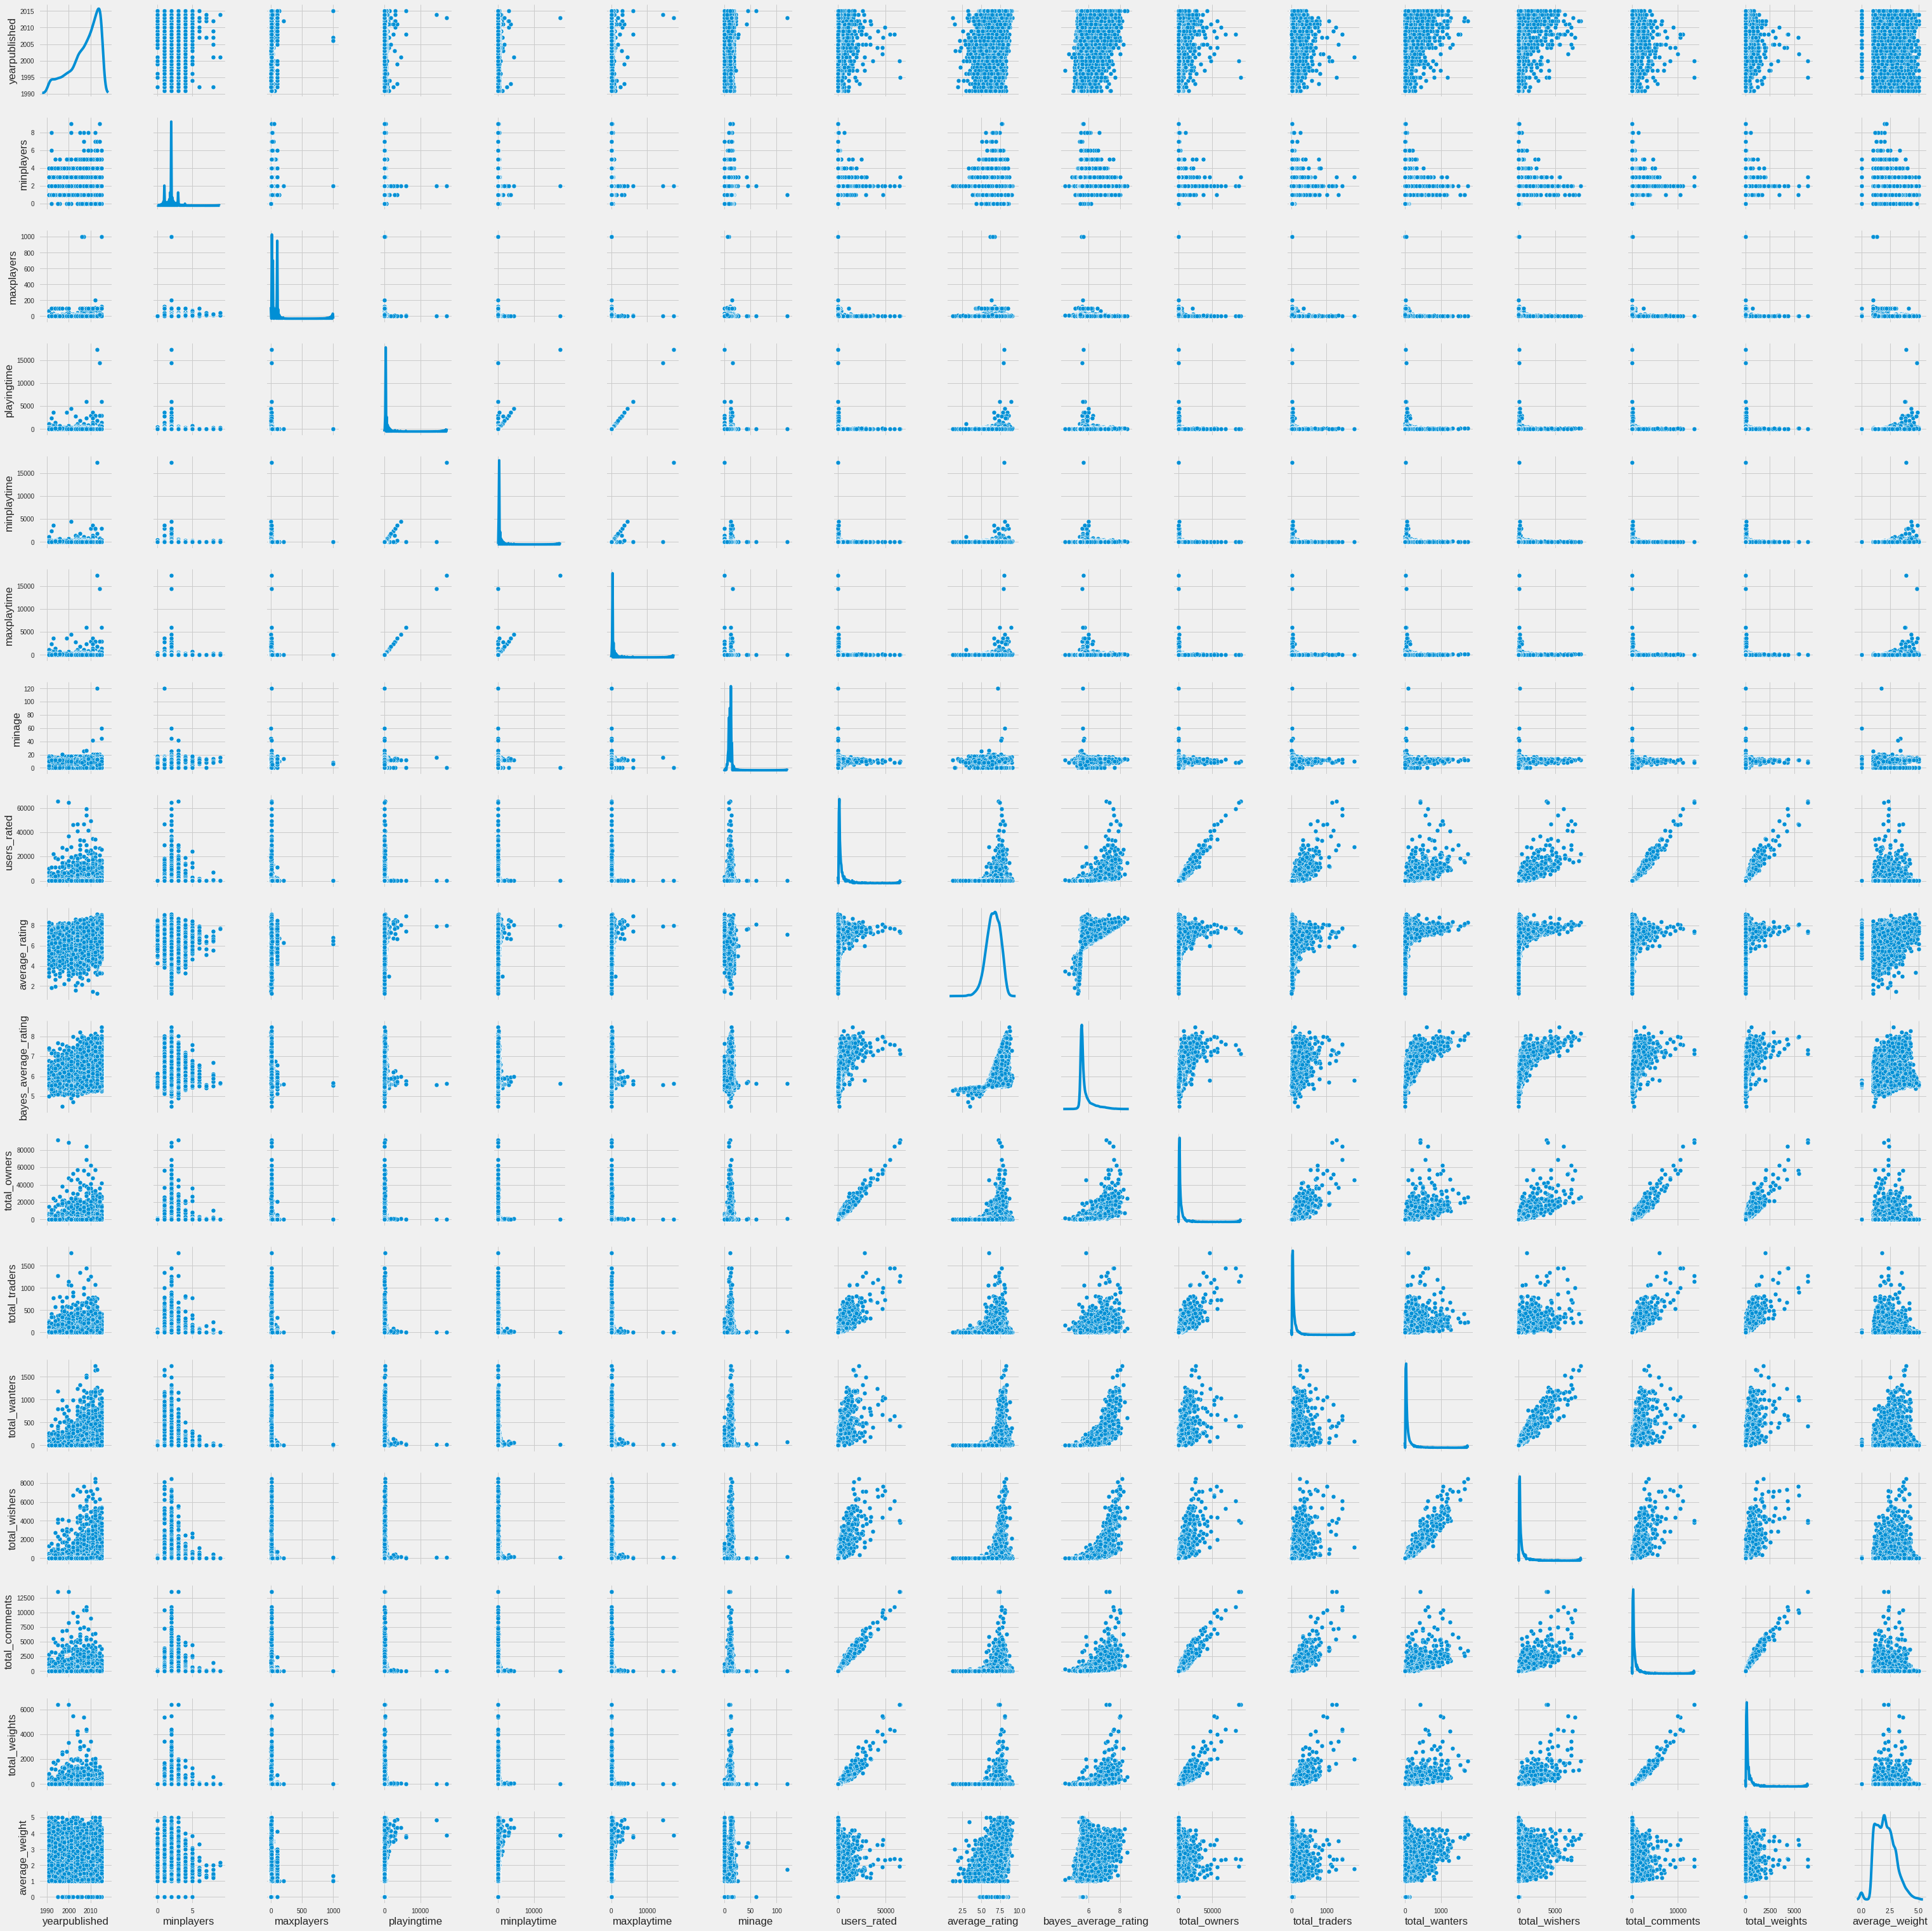

In [9]:
fig = plt.figure()
plt.style.use('fivethirtyeight')
sns.pairplot(games, kind='scatter', diag_kind='kde');
plt.show();
#plt.savefig('pairplot_numeric.png');

We can see 5 major linear correlations in the pair plot:

1. total_owners & users_rated
2. total_owners & total_weights
3. total_owners & total_comments
4. users_rated & total_weights
5. users_rated & total_comments

In [15]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5)
cluster.fit(games)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

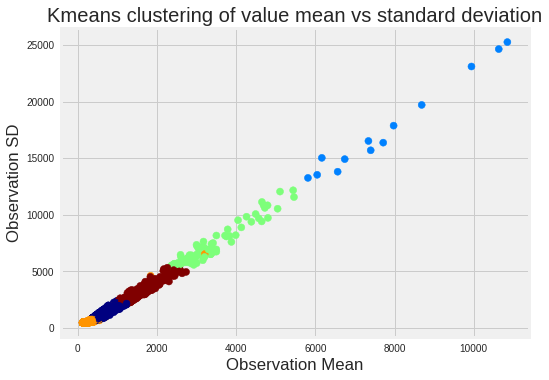

In [16]:
import matplotlib.cm as cm

fig=plt.figure()
plt.style.use('fivethirtyeight')
plt.scatter(x=games.apply(np.mean, axis=1), y=games.apply(np.std, axis=1),
            c=cluster.labels_, cmap='jet');
plt.xlabel('Observation Mean')
plt.ylabel('Observation SD')
plt.title('Kmeans clustering of value mean vs standard deviation')
plt.tight_layout()
plt.show()
#fig.savefig('cluster_mean_std.png')

This graph compares observation means and standard deviations. Although the metrics are not useful in themselves, it's interesting to look at them compared to other observations. What this graph shows is that many games are similiar. However, there is a small cluster (light green) that has very large values in their features. Essentially, most games have few ratings, owners, comments, etc.. but a few games generate an enormous amount of activity/volume.

In [17]:
correlations = games.corr()
correlations['average_rating']

yearpublished           0.348639
minplayers             -0.169357
maxplayers             -0.024367
playingtime             0.118681
minplaytime             0.114625
maxplaytime             0.118681
minage                  0.141881
users_rated             0.153301
average_rating          1.000000
bayes_average_rating    0.516445
total_owners            0.206832
total_traders           0.081275
total_wanters           0.318231
total_wishers           0.257790
total_comments          0.152957
total_weights           0.133433
average_weight          0.510265
Name: average_rating, dtype: float64

#### Explanation of average_weight
This is a community generated metric from BoardGameGeek. It is defined as "Community rating for how difficult a game is to understand. Lower rating (lighter weight) means easier." 

#### Explanation of total_wanters
This is the number of people who are looking for this game in the BoardGameGeek marketplace.

#### Explanation of total_wishers
This is the number of people who have added this game to their wishlist. 

In [18]:
#isolate the Target
y = games.pop('average_rating')
y = y.astype('float', copy=False)
print(y.dtype)
print(y.shape)

float64
(13598,)


In [19]:
#reduce complexity by removing uncorrelated features
#also remove features that have collinearity
#delete other avg rating
games.drop(['bayes_average_rating', 'total_traders', 'total_weights', 'total_comments', 'users_rated'],axis=1, inplace=True)
games.head()

,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,total_owners,total_wanters,total_wishers,average_weight
2,1997.0,1.0,2.0,180.0,180.0,180.0,14.0,117.0,0.0,4.0,3.5556
5,2001.0,2.0,4.0,45.0,45.0,45.0,12.0,739.0,3.0,14.0,1.8684
12,2006.0,2.0,2.0,30.0,30.0,30.0,10.0,1808.0,53.0,205.0,2.4485
28,2011.0,3.0,5.0,50.0,50.0,50.0,14.0,251.0,49.0,120.0,1.4706
32,2001.0,2.0,2.0,20.0,20.0,20.0,10.0,571.0,11.0,19.0,1.5385


# Applying Linear Regression with L1 Regularization

In [20]:
# preprocess, instantiate model, fit the data to the model
games_standardized = preprocessing.scale(games)
lasso_cv = linear_model.LassoCV(cv=5, normalize=False, verbose=True, random_state=8)
lasso_cv.fit(games_standardized, y)
alpha_lasso = lasso_cv.alpha_
lasso_coef = lasso_cv.coef_
print(lasso_coef)
lasso = linear_model.Lasso(alpha=alpha_lasso, random_state=8)
lasso.fit(games_standardized, y)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


[ 0.31977862 -0.04933663  0.01243574  0.00374256  0.01611358  0.0012954
  0.01437157  0.23118331  0.61730485 -0.63864544  0.41574556]


Lasso(alpha=0.0011612976338330402, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=8, selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
cv_score_lasso = cross_val_score(lasso_cv, games_standardized, y, cv=5, scoring='neg_mean_squared_error', verbose=0)
rmse_lasso = np.mean(-cv_score_lasso) ** (0.5)
rmse_lasso

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
..............................................................................................................................................................................................................................................................................................................................................................................................................................................

0.679433492610936

Since we are interpretting MSE by its root, this put's our error metric in terms of $Average Rating$ - not $(Average Rating)^2$. This model, on average, is within 0.68 "stars" out of ten from the actual rating. 

# Applying Linear Regression with L2 Regularization

In [109]:
ridge_cv = linear_model.RidgeCV(cv=5, normalize=False)
ridge_cv.fit(games_standardized, y)
alpha_ridge = ridge_cv.alpha_
ridge_coef = ridge_cv.coef_
print(ridge_coef)
ridge_cv = linear_model.Ridge(alpha=alpha_ridge, random_state = 8)
ridge_cv.fit(games_standardized, y)

[ 0.32100285 -0.05039445  0.01375012  0.00286474  0.01674359  0.00286474
  0.01529783  0.24030501  0.63912382 -0.66750468  0.41545838]


Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=8, solver='auto', tol=0.001)

In [99]:
cv_score_ridge = cross_val_score(ridge_cv, games_standardized, y, cv=5, scoring='mean_squared_error')
rmse_ridge = np.mean(-cv_score_ridge) ** (0.5)
rmse_ridge

0.6793923373719547

So both forms of regularization produced very similiar results. We know that $L2$ (Ridge) is robust and provides a unique solution. $L1$ will provide one of what is usually a set of possible solutions. We can see how similiar the models produced are by the absolute value of the difference of their coefficients. 

In [92]:
difference = np.absolute(np.subtract(lasso_coef, ridge_coef))
print(difference)

[ 0.00122423  0.00105783  0.00131438  0.00087782  0.00063002  0.00156934
  0.00092626  0.0091217   0.02181897  0.02885924  0.00028718]


The features that correlate to the largest difference are **total_wanters** and **total_wishers**. It's possible that increasing the number of alphas tested in `LassoCV()` may yield a model even closer to $L2$. 

# LET'S FIND OUT!!!!

In [110]:
#we will use 5 times as many alphas
lassoT_cv = linear_model.LassoCV(cv=5, n_alphas=500, normalize=False, verbose=True, random_state=8)
lassoT_cv.fit(games_standardized, y)
alphaT_lasso = lassoT_cv.alpha_
lassoT_coef = lassoT_cv.coef_
print(lassoT_coef)
lasso_T = linear_model.Lasso(alpha=alphaT_lasso)
lasso_T.fit(games_standardized, y)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 0.31976778 -0.04933048  0.01242661  0.00373719  0.01610949  0.00129619
  0.01436647  0.23109295  0.6170705  -0.63834188  0.41574785]


Lasso(alpha=0.0011689548424691108, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [113]:
cv_score_lassoT = cross_val_score(lasso_T, games_standardized, y, cv=5, scoring='mean_squared_error')
rmse_lassoT = np.mean(-cv_score_lassoT) ** (0.5)
rmse_lassoT

0.67930633725683587

In [111]:
difference_test = np.absolute(np.subtract(lasso_coef, ridge_coef))
alpha_hypothesis = np.absolute(np.subtract(difference, difference_test))
print(alpha_hypothesis)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


# SCIENCE BITCH     (╯°□°）╯︵ ┻━┻

As you can see, we found the *optimal* value of $\lambda$ for $L1$. This means that the regularization error terms are equal. 

<h1><center> $ \sum||\beta||_2  = \sum|\beta|^2_2 $</center></h1>

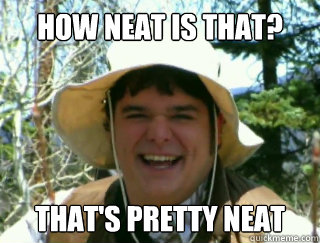

In [95]:
from IPython.display import Image
Image(filename='neat.jpg') 

# Comparing Training Error with CV Error

We want to compare our cross-validated model's error against the error produced by training the entire dataset without cross-validation. The $\lambda$ will come from the optimized `LassoCV`.

In [117]:
non_cv = linear_model.Lasso(alpha=alphaT_lasso)
non_cv.fit(games_standardized, y)

non_cv_predictions = non_cv.predict(games_standardized)
cv_mse_predictions = lasso_T.predict(games_standardized)

non_cv_mse = mean_squared_error(y, non_cv_predictions)
cv_mse = mean_squared_error(y, cv_mse_predictions)

print("Training error: {}".format(non_cv_mse))
print("Cross-validated error: {}".format(cv_mse))
print("Are they the equal? {}".format(non_cv_mse == cv_mse))

Training error: 0.45942496793575494
Cross-validated error: 0.45942496793575494
Are they the equal? True


# What does it all mean?

This means my model is extremely underfitted because I have a high error rate, but a small difference between my training error and cross validated error. There is a lack of complexity - perhaps not in the *number* of features, but definitely in their richness or utility. Replacing features with more meaningful or indicative features is a starting place to improving the model. 

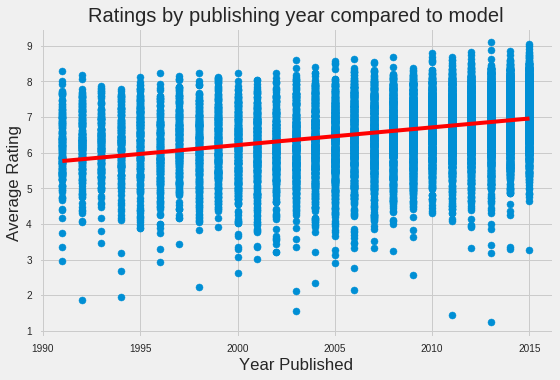

In [197]:
fig = plt.figure()
plt.style.use('fivethirtyeight')
plt.scatter(games['yearpublished'], y)
plt.plot(np.unique(games['yearpublished']),
        np.poly1d(np.polyfit(games['yearpublished'],
        cv_mse_predictions, 1))(np.unique(games['yearpublished'])),
        color='red');
plt.xlabel('Year Published')
plt.ylabel('Average Rating')
plt.title('Ratings by publishing year compared to model')
plt.tight_layout()
plt.show();
#fig.savefig('regplot-year.png')

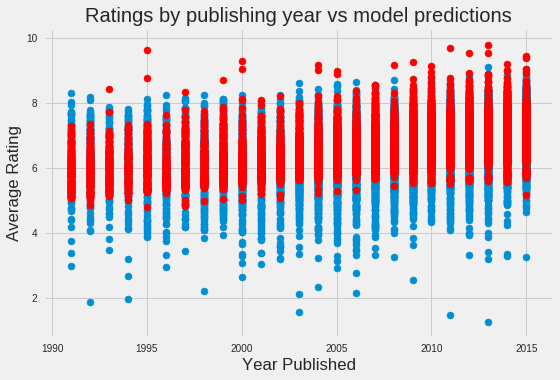

In [198]:
fig = plt.figure()
plt.style.use('fivethirtyeight')
plt.scatter(games['yearpublished'], y)
plt.scatter(games['yearpublished'], cv_mse_predictions, color ='red')
plt.xlabel('Year Published')
plt.ylabel('Average Rating')
plt.title('Ratings by publishing year vs model predictions')
plt.tight_layout()
plt.show();
#fig.savefig('regplotscatter-year.png')

# Looking forward

This project was a nice practice, but not very exciting as far as results. Ultimately, my features were not very rich. Most trends in average rating are explained by a few things:

1) More recent games are rated highly as there is an increased user population on BoardGameGeek
2) Average being correlated with the number of people who are interested in the game in any capacity is basically self-explanatory. 

The ***MAJOR*** problem with the model is that the features tell us very little *useful* information about the game itself. 

### Solution:

The XML pages that are being scraped have more nuanced information about the games. 

In [ ]:
<poll name="suggested_playerage" title="User Suggested Player Age" totalvotes="0"></poll>
<poll name="language_dependence" title="Language Dependence" totalvotes="0"></poll>
<link type="boardgamecategory" id="1002" value="Card Game"/>
<link type="boardgamecategory" id="1031" value="Racing"/>
<link type="boardgamemechanic" id="2040" value="Hand Management"/>
<link type="boardgamefamily" id="17438" value="Mille Bornes"/>
<link type="boardgamefamily" id="18055" value="Pixar Cars"/>
<link type="boardgamedesigner" id="3" value="(Uncredited)"/>
<link type="boardgamepublisher" id="3082" value="Dujardin"/>

Creating dummy variables for things like game category and mechanics could be much more indicative of average score. Almost more importantly, this data could be used for unsupervised learning and clustered by average ratings and publishing years. This could be used to identify trends in categories and mechanics and make accurate predictions about games that will be released in the near future. 